In [1]:
%load_ext autoreload
%autoreload 2

# Densenet-121-56x56

This notebook was build to extract features from a DenseNet-121 trained to identify the presence of malign or bening lesions in patches of size 256x256. The patches are subsamples of full size mammographies, as the ones we are using to feed the generative models.

The features are extracted at the end of the feature section of DenseNet, before the linear classifier.

**Some details of DenseNet-121:**
* Four denseblocks with (6, 12, 24, 16)x2 conv layers respectively. The x2 is because it has a Conv1x1 and Conv3x3.
* Three transition layers with one conv layer each.
* One input and one output layer. (still need to check this)
* Final layer count: (6 + 12 + 24 + 16)x2 + 5 = 121

In [2]:
import sys
sys.path.insert(0,'/home/fede/Documents/mhpc/mhpc-thesis/code/breast_cancer_classifier')

import numpy as np
import random
import os
import argparse
import tqdm

import torch
import torch.nn.functional as F

from torchvision import models, transforms
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import os,sys

from mm_patch.data import PatchesDataset
import mm_patch.transforms


# NYU breast cancer scripts
import src.heatmaps.models as models
import src.heatmaps.run_producer as run

In [3]:
# Transformations to be compatible with Densenet-121 from NYU paper.
# Note I am using mean and std as recommended in Pytorch. Maybe calculating the dataset statistics is better.
composed = transforms.Compose([ 
#                                 mm_patch.transforms.ToImage(),
                                transforms.ToTensor(),
                                mm_patch.transforms.Scale(),
                                transforms.ToPILImage(),
                                transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                mm_patch.transforms.GrayToRGB(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

# Set dataset
patches = PatchesDataset(data_path='./patches_56x56.pkl', transform = composed)

# Dataloader parameters
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(patches)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# this train loader is to have random access
loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
                                            num_workers=4)
train_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4)

## Densenet-121 Model 
We have to load the model parameters from the NYU breast_cancer_classifier github: 
'./models/sample_patch_model.p'

In [4]:
parameters = {}

parameters['device_type'] = "cpu"
parameters['gpu_number'] = 0
parameters['number_of_classes'] = 4
parameters['initial_parameters'] = '/home/fede/Documents/mhpc/mhpc-thesis/code/breast_cancer_classifier/models/sample_patch_model.p'

model, device = run.load_model(parameters)

In [5]:
# from torchsummary import summary
# # summary(your_model, input_size=(channels, H, W))
# summary(model, input_size=(3, 256, 256))

In [6]:
# Easy way of checking layer names (you have to be careful because names are not exactly the same)
# model.state_dict().keys()

In [7]:
batch = next(iter(loader))

batch['patch'].shape

# with torch.no_grad():
#     output = [(densenet(batch['patch']), batch['target']) for batch in loader]
    
    

#     with torch.no_grad():
#         output = F.softmax(model(torch.FloatTensor(minibatch_x).to(device)), dim=1).cpu().detach().numpy()
#     return output


torch.Size([4, 3, 256, 256])

## Set up hooks

In [8]:
# get activations
def get_activation(layer_dict, name):
    """
    Define hook to extract intermediate layer features
    """
    def hook(model, input, output):
        layer_dict[name].append(output.detach())
        # layer_dict[name] = torch.cat(layer_dict[name], output.detach())
    return hook

In [9]:
# register hook
activations = {'norm5': []}
handle_linear = model.densenet.features.norm5.register_forward_hook(get_activation(activations, 'norm5'))

In [10]:
from tqdm import tqdm as tqdm
with torch.no_grad():
#     output = [(densenet(batch['patch']), batch['target']) for batch in loader]
        output = [F.softmax(model(torch.FloatTensor(batch['patch']).to(device)), dim=1).cpu().detach().numpy() 
                  for batch in tqdm(loader)]


100%|██████████| 700/700 [04:12<00:00,  2.72it/s]


## Intrinsic Dimension

In [38]:
import sys
sys.path.insert(0,'/home/fede/Documents/mhpc/mhpc-thesis/code/TWO-NN')
import id2nn

### Activation before linear classifier (ED = 1024)

To get the activation before the linear classifier we have to take the output of densenet.feature, activations\['norm5'\], and apply an F.adaptive_avg_pool2d + a flatten operation.

In numbers:

```
activation['norm5'] = (n_batch, 1024, 8, 8)
F.adaptive_avg_pool2d(out_batch, (1, 1)).view(n_batch, -1) = (n_batch, 1024)
```
Thus the input of the classifier is of dimension 1024.



In [12]:
features = [ F.adaptive_avg_pool2d(out_batch, (1, 1)).view(4, -1) for out_batch in activations['norm5'] ] 
# we concatenate all the batches
features = torch.cat(features, 0)

In [13]:
np.random.seed(10)

# dim, mu, mu_cs = two_nn_id(data, 0.9)

blocks_dim, blocks_dim_std, blocks_size, d_mat2 = id2nn.two_nn_block_analysis(features.numpy(), .9, shuffle = True)

# print(len(blocks_dim))
# # print(len(blocks_dim_std))

# file_path = './activations_alexnet/block_analysis_linear.txt'
# with open(file_path, 'wb') as file: 
#     np.savetxt(file, np.array(blocks_dim))
#     np.savetxt(file, np.array(blocks_dim_std))



  0%|          | 5/2800 [00:00<01:07, 41.58it/s]

Start shuffle..
Finished shuffle
Start dist_mat


  0%|          | 0/20 [00:00<?, ?it/s]

Finished dist_mat


100%|██████████| 20/20 [00:04<00:00, 10.63it/s]


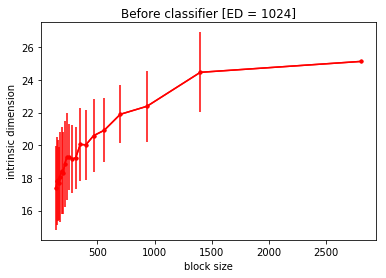

In [14]:
import matplotlib.pyplot as plt

plt.plot(blocks_size, blocks_dim, "r.-")
plt.errorbar(blocks_size, blocks_dim, fmt = "r.-", yerr = np.array(blocks_dim_std))
plt.xlabel('block size')
plt.ylabel('intrinsic dimension')
plt.title('Before classifier [ED = 1024]')
plt.show()

### ID for input data

In [36]:
# build data into single numpy array
input_data = []
for row in patches.data['patch']:
    row = np.array(row)
#     print(type(row))
#     print(row)
    input_data.append(row.flatten(-1))
    
input_data = np.asarray(input_data)
input_data.shape


/opt/miniconda/envs/phang/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  import sys


(2800, 3136)

In [46]:
import id2nn
# calculate id
blocks_dim_input, blocks_dim_std_input, blocks_size_input, _ = id2nn.two_nn_block_analysis(input_data, .9, shuffle = True)

  0%|          | 3/2800 [00:00<01:36, 29.04it/s]

Start shuffle..
Finished shuffle
Start dist_mat


  0%|          | 0/20 [00:00<?, ?it/s]

Finished dist_mat


100%|██████████| 20/20 [00:03<00:00, 11.28it/s]


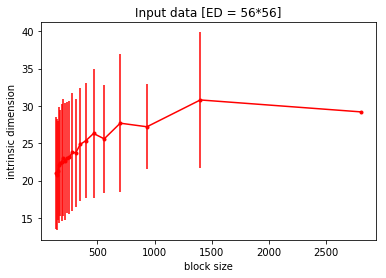

In [45]:
plt.errorbar(blocks_size_input, blocks_dim_input, fmt = "r.-", yerr = np.array(blocks_dim_std_input))
plt.xlabel('block size')
plt.ylabel('intrinsic dimension')
plt.title('Input data [ED = 56*56]')
plt.show()

### Feature extraction without average layer

In [18]:
features_bis = [ out_batch.view(4,-1) for out_batch in activations['norm5'] ] 

In [19]:
features_bis = torch.cat(features_bis, 0)

In [20]:
features_bis.shape

torch.Size([2800, 65536])

In [21]:
# calculate id
blocks_dim_noavg, blocks_dim_std_noavg, blocks_size_noavg, _ = id2nn.two_nn_block_analysis(features_bis.numpy(), .9, shuffle = True)

  0%|          | 0/2800 [00:00<?, ?it/s]

Start shuffle..
Finished shuffle
Start dist_mat


  0%|          | 0/20 [00:00<?, ?it/s]

Finished dist_mat


100%|██████████| 20/20 [00:04<00:00, 10.98it/s]


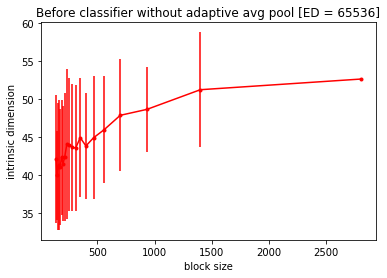

In [22]:
plt.errorbar(blocks_size_noavg, blocks_dim_noavg, fmt = "r.-", yerr = np.array(blocks_dim_std_noavg))
plt.xlabel('block size')
plt.ylabel('intrinsic dimension')
plt.title('Before classifier without adaptive avg pool [ED = 65536]')
plt.show()

## PCA

In [23]:
from numpy import linalg as LA
from numpy import cov
from sklearn import preprocessing
from sklearn.decomposition import PCA

features shape before(2800, 1024)
torch.Size([2800, 1024])
78
features shape after(2800, 78)


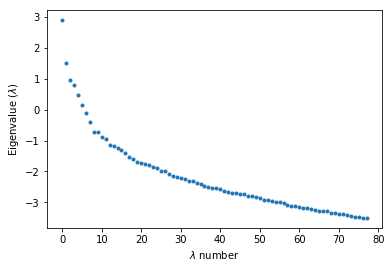

In [24]:
x = features.numpy()

print(f'features shape before{x.shape}')
# define scaler instance
scaler = preprocessing.StandardScaler()

print(features.shape)
# features_ts = scaler.fit_transform(features)
x_centered = x - np.mean(x, axis=0)


# Own implementation (stability error)
# cov_mat = cov(x_centered.T)
# print(cov_mat.shape)

# # Calculate Eigenvectors and Eigenvalues
# w, v = LA.eig(cov_mat)
# print("w:", w)
# # print("v:", v)



# Using scipy package


# percentage of variance explained
# can also use: PCA(n_components=2)
pca = PCA(n_components=0.95)
x_centered = pca.fit_transform(x_centered)
# pca.explained_variance_ are the eigenvalues
eigenvalues = pca.explained_variance_ 
print(len(eigenvalues))
# pca.components_ are the eigenvectors
# print(pca.components_[1,:])

print(f'features shape after{x_centered.shape}')

# Plot eigenvalues 
plt.plot(np.log(eigenvalues), '.')
plt.ylabel('Eigenvalue $(\lambda)$')
plt.xlabel('$\lambda$ number')
plt.show()

In [25]:
# print(features.shape)
file_path = './activations_densenet/features_pca_0.95_56x56.txt'
with open(file_path, 'w') as file: 
    np.savetxt(file, x_centered)


(2800, 78)

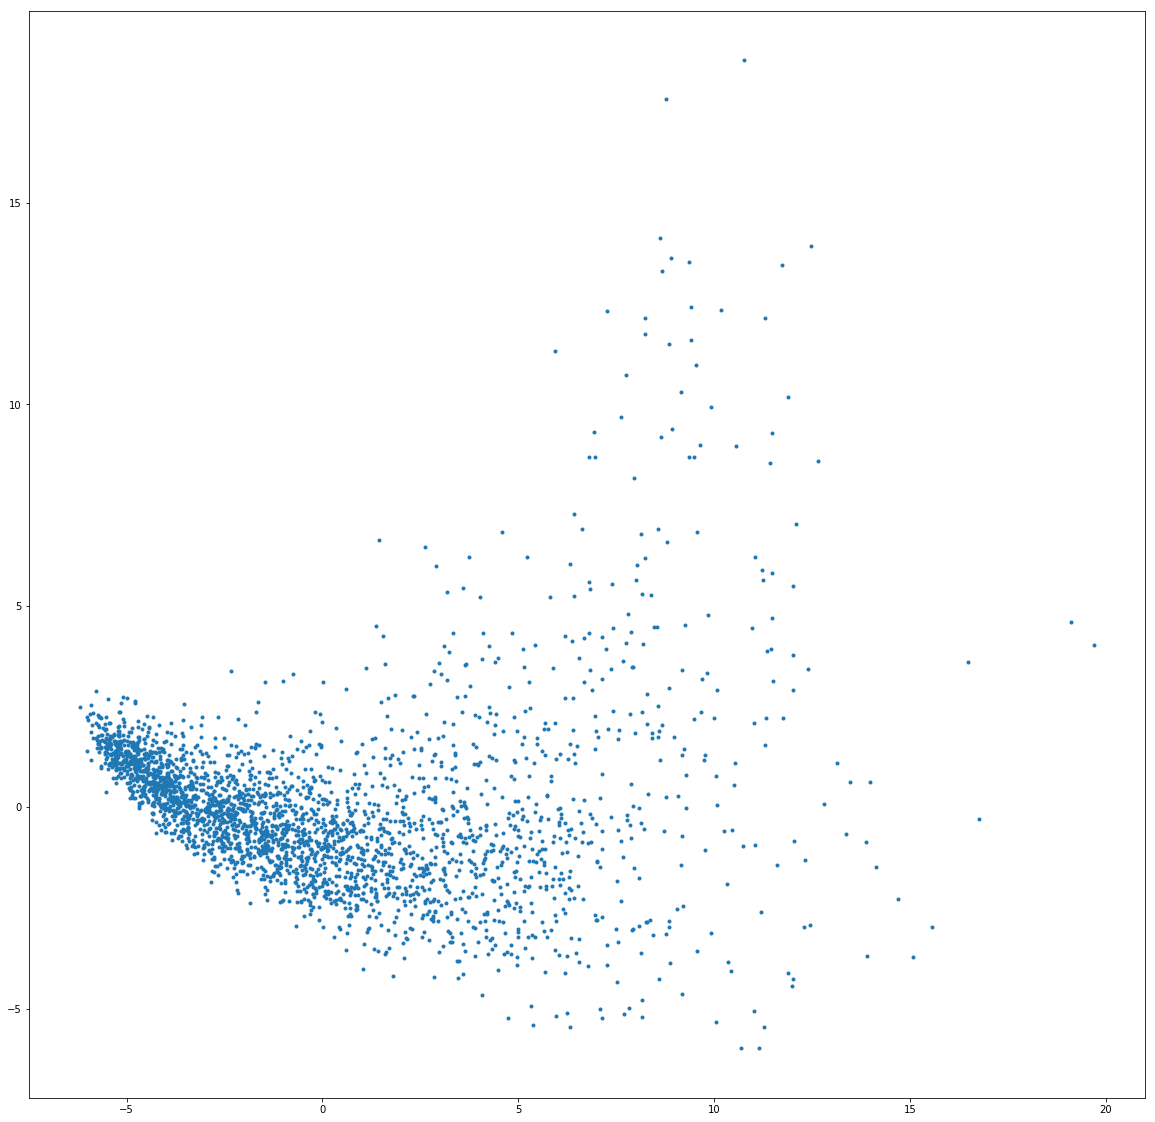

In [26]:
fig = plt.figure(figsize = (20,20))
plt.plot(x_centered[:,0],x_centered[:,1], '.')
x_centered.shape

## TSNE

In [27]:
import numpy as np
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2, perplexity = 100).fit_transform(x_centered)
x_embedded.shape


(2800, 2)

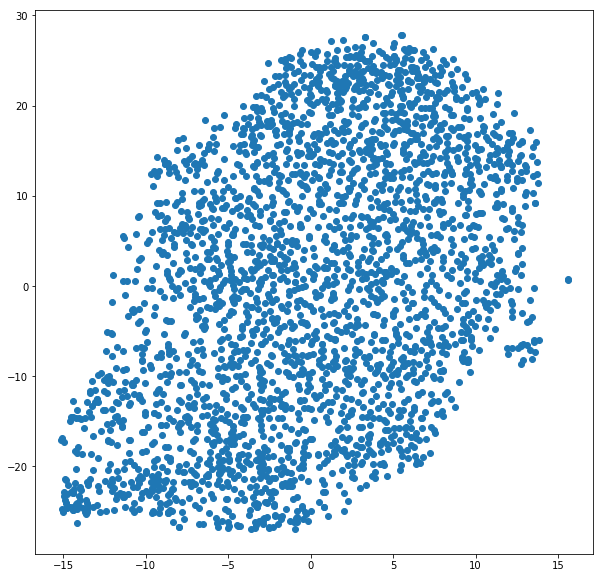

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(x_embedded[:,0],x_embedded[:,1])

## Save results

In [29]:
# # print(features.shape)
# file_path = './activations_densenet/before_classification.txt'
# with open(file_path, 'w') as file: 
#     np.savetxt(file, features)


## K-Means

In [30]:
# print(features.shape)
file_path = './activations_densenet/features_pca_0.95.txt'
with open(file_path, 'r') as file: 
    X = np.loadtxt(file)


In [31]:
from sklearn.cluster import KMeans


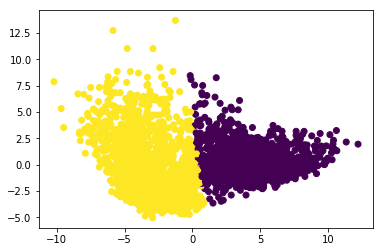

In [32]:
kmeans = KMeans(n_clusters=2).fit(X)
plt.scatter(X[:,0], X[:,1], c = kmeans.labels_)

In [33]:
data =  patches.data['patch']

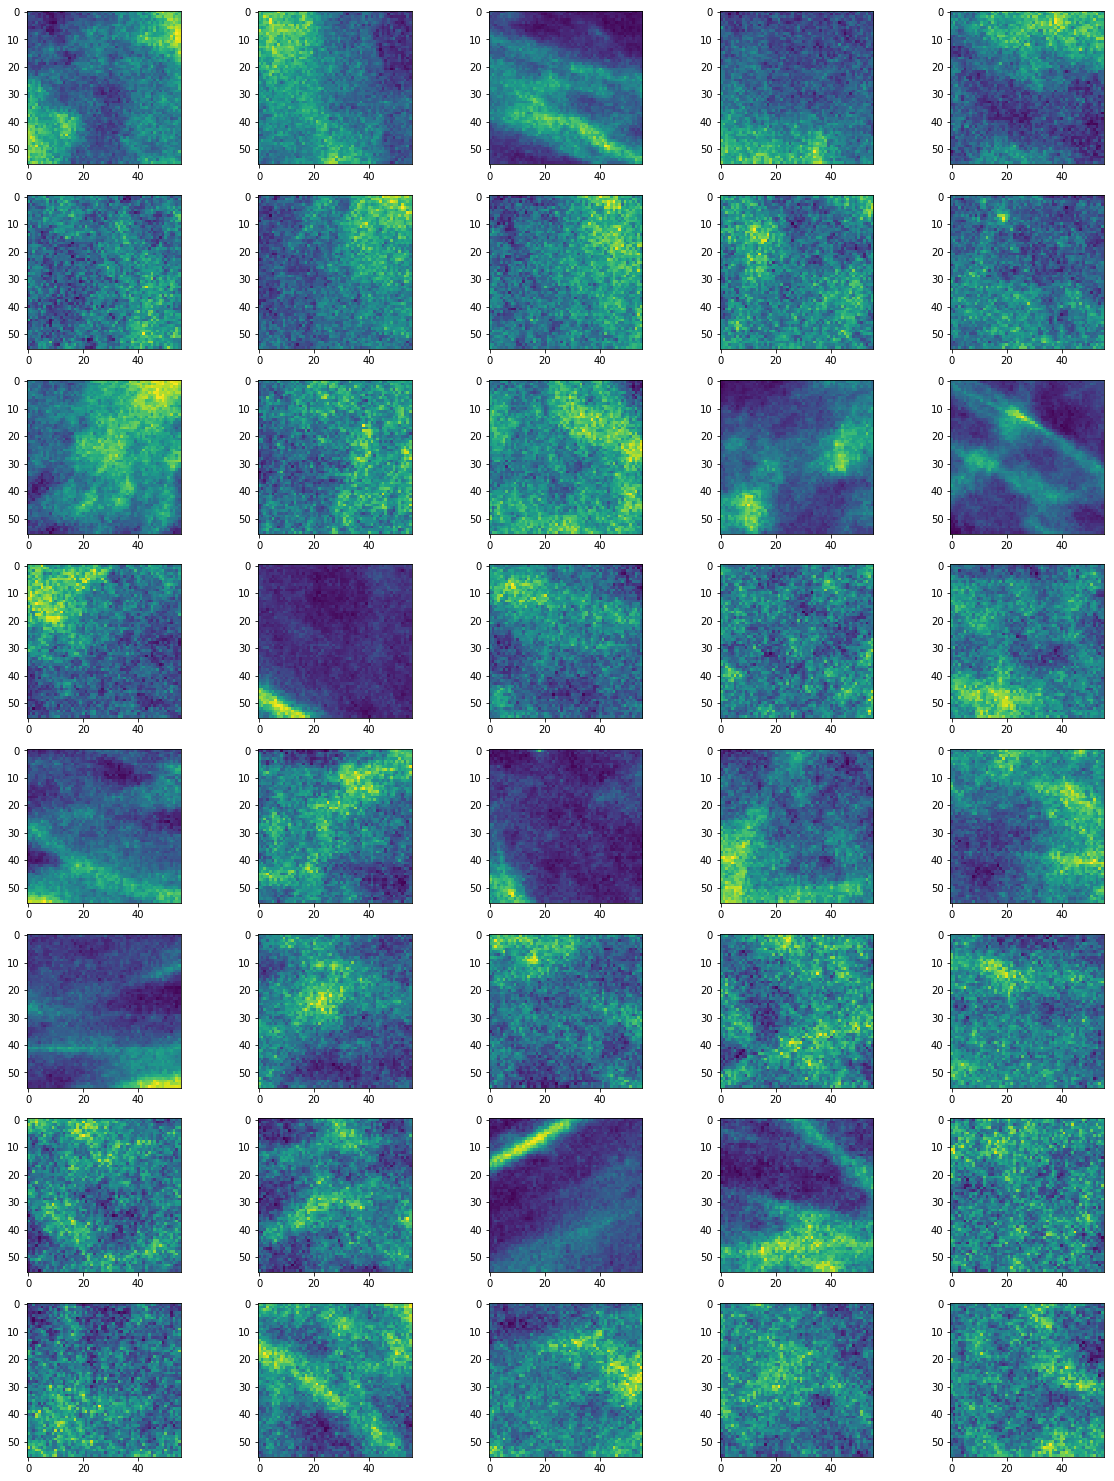

In [34]:
num_patches = 40
cluster = 0
fig = plt.figure(figsize = (20,30))
cols = 5
rows = num_patches//cols + 1
for i,patch in enumerate(data[kmeans.labels_ == cluster][:num_patches]):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(patch)
plt.show()